In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time
import pickle as pkl
from scipy import stats

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import category_encoders as ce

# for classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score,multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Preprocessing of the data

In [2]:
# load and import the data
df_model = pd.read_csv('df_model_v4.csv')

In [4]:
def drop_columns(df):
    '''
    Drop columns from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to drop columns from

        
    Returns
    -------
    df : pandas dataframe
        The dataframe with the columns dropped
    '''
    
    #'ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE'

    cols_to_drop = ['RFM_BUYER', 'ORDER_VALUE_RANGE','ID_CONDITION', 'ORDER_MARKETING_CHANNEL' , 
                   'Total_likes', 'Total_wishes', 'Total_MMAO_NB', 'Avg_commision_x' , 'Avg_commision_y', 
                   'NL_REACTIVITY_GROUP','NB_PURCHASED', 'RANK_BUYER', 'BUYER_SEGMENT', 'NB_SOLD','RANK_WITHIN_SEGMENT', 
                   'ID_SEGMENT', 'ID_RFM_BUYER','Frequnecy_like_12M']
    
    #
    #'NB_products_liked'

    to_drop_maybe = ['NB_products_liked','NB_categories_liked', 'NB_products_commented', 'NB_categories_commented']

    df.drop(cols_to_drop, axis=1, inplace=True)

    return df

In [5]:
def date_time_converting(df):
    '''
    Convert the date columns to datetime and create new columns for the number of days 
    between the first order and the creation of the account

    Parameters
    ----------

    df : pandas dataframe
    The dataframe to convert the date columns to datetime and create new columns for the 
    number of days between the first order and the creation of the account

    Returns
    -------
    df : pandas dataframe
    The dataframe with the date columns converted to datetime and new columns for the

    '''
    # Convert the date columns to datetime
    df['DATE_CREATION'] = pd.to_datetime(df['DATE_CREATION'])
    df['DATE_FIRST_PURCHASE'] = pd.to_datetime(df['DATE_FIRST_PURCHASE'])
    df['DATE_LAST_LOGIN'] = pd.to_datetime(df['DATE_LAST_LOGIN'])
    df['DATE_LAST_PURCHASE'] = pd.to_datetime(df['DATE_LAST_PURCHASE'])

    # Create a new column for the number of days between the first order and the creation of the account
    df['days_bf_first_order'] = (df['DATE_FIRST_PURCHASE'] - df['DATE_CREATION']).dt.days

    # recency login compared to today
    df['days_since_last_login'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_LOGIN']).dt.days

    # recency order compared to today
    #df['days_since_last_order'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_PURCHASE']).dt.days

    # Drop the date columns
    df.drop(['DATE_CREATION', 'DATE_NEW_BUYER', 'LastLikeDate', 'LastCommentDate', 
             'DATE_FIRST_PURCHASE', 'DATE_LAST_LOGIN', 'DATE_LAST_PURCHASE'], axis=1, inplace=True)
    df.drop(['Total_nb_likes', 'Total_nb_wish'], axis=1, inplace=True)

    return df

In [6]:
def missing_values(df):
    # Dealing with the missing values

    # Replacing the missing values with 0 
    df['NB_products_liked'].fillna(0, inplace=True)
    df['NB_categories_liked'].fillna(0, inplace=True)
    #df['Frequnecy_like_12M'].fillna(0, inplace=True)
    df['NB_products_commented'].fillna(0, inplace=True)
    df['NB_categories_commented'].fillna(0, inplace=True)
    df['Frequnecy_comment_12M'].fillna(0, inplace=True)

    # Replacing the missing values with 999
    df['Recency_comment'].fillna(999, inplace=True)
    df['Recency_liked'].fillna(999, inplace=True)

    return df

In [7]:
import category_encoders as ce

cols_to_encode = ['ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE']

def target_encoding(train_df, valid_df, cols_to_encode, target_col):
    """
    Apply target encoding to a set of columns and avoid data leakage.
    
    Args:
        train_df (pandas.DataFrame): The training data.
        valid_df (pandas.DataFrame): The validation/test data.
        cols_to_encode (list of str): The names of the columns to encode.
        target_col (str): The name of the target column.
    
    Returns:
        pandas.DataFrame: The training data with target-encoded columns,
                           and the validation/test data with corresponding target-encoded columns.
    """
    # Create a TargetEncoder object
    te = ce.TargetEncoder()
    
    # Fit the target encoder on the training data
    te.fit(train_df[cols_to_encode], target_col)
    
    # Transform the training and validation/test data separately
    train_encoded = te.transform(train_df[cols_to_encode])
    valid_encoded = te.transform(valid_df[cols_to_encode])
    
    # Replace the original columns with the encoded columns in the training and validation/test data
    train_df = train_df.drop(cols_to_encode, axis=1)
    train_df = pd.concat([train_df, train_encoded], axis=1)
    
    valid_df = valid_df.drop(cols_to_encode, axis=1)
    valid_df = pd.concat([valid_df, valid_encoded], axis=1)
    
    return train_df, valid_df

def encoding(df):
    ### ecoding the categorical variables 
    
    ##ordinal encoding
    # USER_SEGMENT
    user_seg_map = {'Hibernating' :0, 'Inactive 6-12M': 1, 'Dormant 6M': 2, 'About to Sleep': 3, 'At High Risk':4, 'At Risk' :5, 'Need Attention':6, 'New Customer': 7, 'Potential Engaged':8, 'Engaged':9, 'Highly Engaged':10}
    df['USER_SEGMENT'] = df['USER_SEGMENT'].map(user_seg_map)


    # if task == 'classification':
    #     class_te(df)
    # elif task == 'regression':
    #     regr_te(df)
    # else: 
    #     print('Target encoding was not choosed for this run')
    # #BUYER_SEGMENT 
    # buyer_seg_map = {'Low potential one timers':0,'High potential one timers' : 1,'Low quality repeaters':2, 'High potential repeaters':3, 'Top buyers - only':4, 'Top buyers - low value': 5, 'Top buyers - high value':6, 'Top buyers - VVIC':7}
    # # OR maybe map with levels 1 to 3 with one timers, repeaters and top buyers
    # df['BUYER_SEGMENT'] = df['BUYER_SEGMENT'].map(buyer_seg_map)
    #drop the columns 

    return df

In [8]:
df = drop_columns(df_model)
df = date_time_converting(df_model)
df = missing_values(df_model)
df = encoding(df_model)

# set ID_BUYER as index

df.set_index('ID_BUYER', inplace=True)

KeyError: "['Total_likes', 'Total_wishes', 'Total_MMAO_NB', 'Avg_commision_x', 'Avg_commision_y', 'Frequnecy_like_12M'] not found in axis"

In [8]:
df.head()

,INACTIVE,NB_PUBLISHED,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,ID_CATEGORY,ID_SUBCATEGORY,ID_BRAND,ID_PAYMENT_TYPE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,ID_GENDER,NB_products_liked,NB_categories_liked,Recency_liked,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
571,0,141,10,0.0,5850.719086,21.0,1.909091,51,13.0,511.0,50,56,526.932084,540.216086,1.0,24.009604,18.007203,0.000000,24.009604,1.0,26.0,3.0,16.0,9.0,3.0,56.0,1383.0,4474,38
6048,0,0,10,0.0,2500.000000,4.0,1.000000,8,141.0,59.0,50,56,0.000000,2016.101923,1.0,0.000000,15.000000,17.500228,0.000000,1.0,267.0,5.0,3.0,2.0,1.0,382.0,0.0,4690,31
16737,0,1,10,0.0,840.000000,15.0,1.153846,83,[ 14. 141.],[ 59. 609.],[ 14 471],[56 65],799.268519,420.000000,1.0,0.000000,0.000000,110.697740,0.000000,1.0,63.0,3.0,0.0,1.0,1.0,44.0,1.0,4223,28
18735,0,0,4,0.0,165.000000,130.0,1.710526,3,12.0,39.0,106,56,100.000000,82.500000,2.0,0.000000,0.000000,0.000000,0.000000,2.0,59.0,5.0,128.0,1.0,1.0,252.0,154.0,4252,60
47068,0,5,6,0.0,425.616576,4.0,1.333333,0,[ 12. 141.],[ 59. 137.],4783,56,136.716329,134.628788,1.0,0.000000,0.000000,-4.233308,0.000000,1.0,4.0,2.0,104.0,0.0,0.0,999.0,0.0,4060,54


In [30]:
def outliers_removal(df, outlier_method:str=None):
    '''
    Remove the outliers from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to remove the outliers from

    outlier_method : str
        The method to use to remove the outliers

    Returns
    -------
    df : pandas dataframe
        The dataframe with the outliers removed
    '''

    if outlier_method == 'IQR':
        # IQR method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

    elif outlier_method == 'zscore':
        # Z-score method
        df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    return df

In [31]:
def select_features(X_train, y_train, X_test, method:str=None, VT_threshold=0.1, KBest_k=10):

    colname = X_train.columns

    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()

    if method == 'variance':
        # create an instance of VarianceThreshold with a threshold of 0.1
        selector = VarianceThreshold(threshold=VT_threshold)

        # fit the selector to the training data
        selector.fit(X_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = selector.get_support() 


        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'univariate':
        # create an instance of SelectKBest with the desired parameters
        selector = SelectKBest(f_regression, k=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'recursive':
        # create an instance of SelectKBest with the desired parameters
        selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    else:
        print('Invalid method')

In [32]:
def corr_plot(df):
    '''
    Plot correlation matrix

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to plot

    Returns
    -------
    plot of correlation matrix
    
    '''

    corr = df.corr()
    f, ax = plt.subplots(figsize=(20, 9))
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask= np.triu(corr, k=1))
    plt.show()

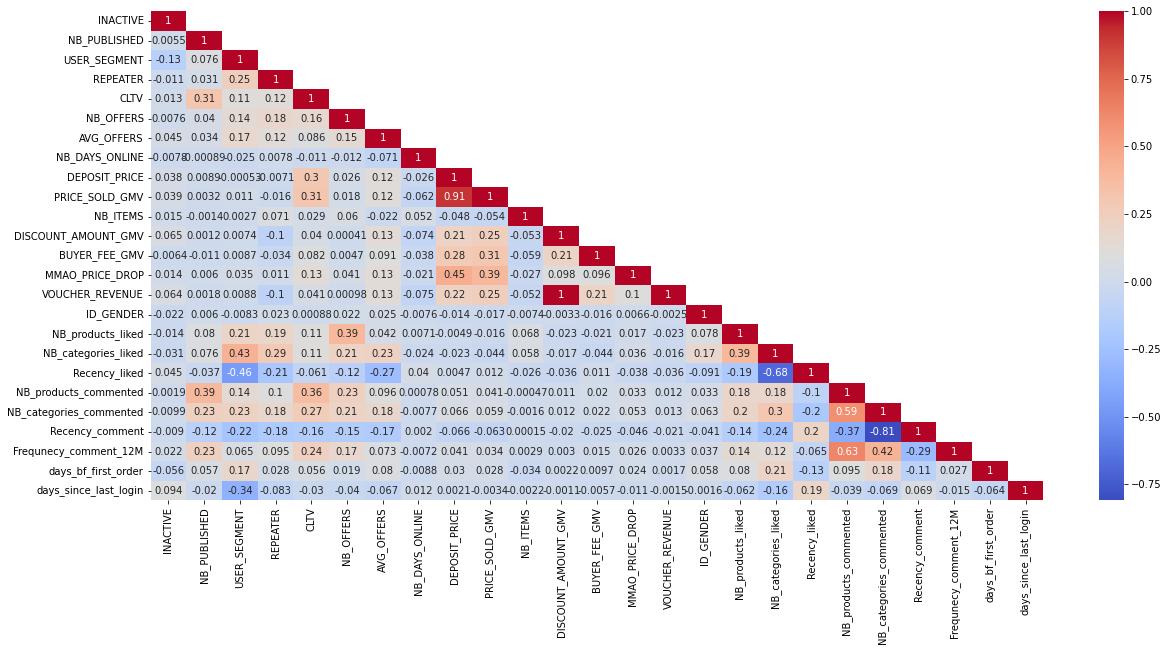

In [33]:
corr_plot(df)

In [34]:
# keep only 10000 rows to have a subset of the data 

df_sample = df.sample(n=10000, random_state=42)

In [35]:
X = df.drop(['REPEATER', 'CLTV'], axis=1) 
y_REPEATER = df['REPEATER']
y_CLTV = df['CLTV']

# keeping colnames for later use

colnames = X.columns

# REPEATER

## split the data into train and test sets, apply target encoding for each model

X_train_REPEATER, X_test_REPEATER, y_train_REPEATER, y_test_REPEATER = train_test_split(X, y_REPEATER, test_size=0.2, random_state=42)

## Apply Target Encoding
X_train_REPEATER, X_test_REPEATER = target_encoding(X_train_REPEATER, X_test_REPEATER, cols_to_encode, target_col=y_train_REPEATER)

# CLTV 

## split the data into train and test sets, apply target encoding for each model

X_train_CLTV, X_test_CLTV, y_train_CLTV, y_test_CLTV = train_test_split(X, y_CLTV, test_size=0.2, random_state=42)

## Apply Target Encoding
X_train_CLTV, X_test_CLTV = target_encoding(X_train_CLTV, X_test_CLTV, cols_to_encode, target_col=y_train_CLTV)

In [16]:
def pre_processing(df, X_train, X_test, scaling:bool = False, scaler:str = None, outliers:bool = False, outliers_method:str = None):
    '''
    Preprocess the data to be used in the model

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to preprocess

    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    Returns
    -------
    X_train : pandas dataframe
        The train set after preprocessing

    X_test : pandas dataframe
        The test set after preprocessing

    '''

    # Scaling the data
    if scaling:
        if scaler == 'MinMaxScaler':
            # MinMaxScaler
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        elif scaler == 'StandardScaler':
            # StandardScaler
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        else:
            print('Please choose a valid scaler')   
    
    return X_train, X_test

# Model 1 : Predicting the probability of a customer to be a Repeater

In [37]:
X_train_REPEATER_scaled, X_test_REPEATER_scaled = pre_processing(df_sample, X_train_REPEATER, X_test_REPEATER, scaling=True, scaler='MinMaxScaler')

Testing different classification models

In [18]:
def classification_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the classification model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_classification_result where each row represents the result of one model
    The columns should be the name of the model, the accuracy score, the precision score, the recall score and the f1 score

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier(), #'SVM': SVC(), 
              'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier( n_jobs=-1),
              'Gradient Boosting': GradientBoostingClassifier(), 'XGBoost': XGBClassifier(verbosity=0, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, random_state=42, objective='binary:logistic'),
                'LightGBM': LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42),
                'CatBoost': CatBoostClassifier(verbose=0, random_state=42, task_type='GPU')}
    
    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for name, model in models.items():
        start = time.time()

        # Perform 5-fold cross validation

        cv = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)

        # Get the mean of the scores

        accuracy = cv['test_accuracy'].mean()
        precision = cv['test_precision'].mean()
        recall = cv['test_recall'].mean()
        f1 = cv['test_f1'].mean()

        # Append the scores to the df_classification_result dataframe

        df_classification_result = df_classification_result.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    
    print('Finished fitting and evaluating all the models')

    df_classification_result = df_classification_result.sort_values(by='F1', ascending=False)

    df_classification_result.reset_index(drop=True, inplace=True)

    return df_classification_result      

In [38]:
df_classification_result = classification_model_testing(df_sample, X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER)

Logistic Regression has been fitted and evaluated
It took 1.6882202625274658 seconds to fit and evaluate the model
--------------------------------------
KNN has been fitted and evaluated
It took 11.667130947113037 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 2.5554544925689697 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 8.051655530929565 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 59.69172120094299 seconds to fit and evaluate the model
--------------------------------------
XGBoost has been fitted and evaluated
It took 2.5334112644195557 seconds to fit and evaluate the model
--------------------------------------
LightGBM has been fitted and evaluated
It took 1.9359512329101562 seconds to fit and evaluate the model
----------------

In [20]:
df_classification_result # with the subset of 10k rows with correct dataset 

,Model,Accuracy,Precision,Recall,F1
7,CatBoost,0.890625,0.735292,0.648363,0.688833
6,LightGBM,0.887375,0.722547,0.644345,0.681078
5,XGBoost,0.886000,0.720816,0.636291,0.675802
4,Gradient Boosting,0.880875,0.723695,0.586737,0.647801
3,Random Forest,0.873000,0.709234,0.542524,0.614448
2,Decision Tree,0.831125,0.547515,0.546544,0.546938
1,KNN,0.850500,0.644823,0.446093,0.526939
0,Logistic Regression,0.848000,0.676906,0.357016,0.467105


In [39]:
df_classification_result # with whole dataset with correct dataset

,Model,Accuracy,Precision,Recall,F1
6,LightGBM,0.890624,0.701071,0.693555,0.697080
7,CatBoost,0.890862,0.707912,0.679629,0.693327
5,XGBoost,0.886738,0.696096,0.668201,0.681688
3,Random Forest,0.883567,0.698518,0.631686,0.663221
4,Gradient Boosting,0.881827,0.698105,0.615266,0.653948
2,Decision Tree,0.851813,0.592141,0.590037,0.590975
1,KNN,0.850025,0.607809,0.489952,0.542400
0,Logistic Regression,0.842492,0.632542,0.315116,0.420643


In [17]:
df_classification_result # with the subset of 10k rows

,Model,Accuracy,Precision,Recall,F1
7,CatBoost,0.819875,0.800711,0.823971,0.812000
6,LightGBM,0.810250,0.788299,0.817885,0.802745
4,Gradient Boosting,0.811500,0.799177,0.802795,0.800797
5,XGBoost,0.799625,0.782393,0.798033,0.789887
3,Random Forest,0.787875,0.778939,0.769448,0.774016
0,Logistic Regression,0.761875,0.746266,0.751976,0.748832
1,KNN,0.744875,0.720630,0.751448,0.735480
2,Decision Tree,0.736625,0.721894,0.720749,0.721096


In [21]:
df_classification_result # with whole dataset

,Model,Accuracy,Precision,Recall,F1
6,LightGBM,0.820385,0.778866,0.854392,0.814871
7,CatBoost,0.821162,0.782540,0.849554,0.814663
5,XGBoost,0.812984,0.773153,0.843211,0.806658
4,Gradient Boosting,0.813135,0.786434,0.818367,0.802076
1,KNN,0.773941,0.741883,0.784296,0.762494
0,Logistic Regression,0.770902,0.759974,0.737891,0.748766
2,Decision Tree,0.736788,0.714510,0.717985,0.716243
3,Random Forest,0.732821,0.714084,0.704673,0.709344


Choice of best models, and hyperparameter tuning

In [18]:
# function for hyper parameter tuning LightGBM 
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42)

    start = time.time()

    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'It took {end-start} seconds or {(end-start) / 60} minutes to fit and evaluate the model')

    print('--------------------------------------')
    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    print('--------------------------------------')

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    # Keep the the predicted probabilty in an array for later use
    
    y_pred_proba = bayes_cv_tuner.predict_proba(X_test)[:,1]

    np.savetxt('REPEATER_pred_proba.txt', y_pred_proba)

    # Evaluate the model

    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy score: {accuracy}')

    precision = precision_score(y_test, y_pred)

    print(f'Precision score: {precision}')

    recall = recall_score(y_test, y_pred)

    print(f'Recall score: {recall}')

    f1 = f1_score(y_test, y_pred)

    print(f'F1 score: {f1}')
    print('--------------------------------------')

    # put results in a dataframe

    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    df_classification_result = df_classification_result.append({'Model': 'LightGBM_tuned', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)

    # Create a confusion matrix

    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))

    # Create a classification report

    print('Classification report: \n', classification_report(y_test, y_pred))

    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()

    # save the model as a pickle file in the models folder

    with open('models/REPEATER_LightGBM_tuned_Subset.pkl', 'wb') as file:
        pkl.dump(bayes_cv_tuner.best_estimator_, file)
    

    return bayes_cv_tuner.best_estimator_, df_classification_result, y_pred_proba

It took 385.24493384361267 seconds or 6.420748897393545 minutes to fit and evaluate the model
--------------------------------------
Best score:  0.82125
Best params:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 7), ('min_child_samples', 92), ('n_estimators', 653), ('num_leaves', 59), ('reg_alpha', 0.24780876747613212), ('reg_lambda', 0.0), ('subsample', 0.7336559844582153)])
--------------------------------------
Accuracy score: 0.7865
Precision score: 0.764102564102564
Recall score: 0.7908704883227177
F1 score: 0.7772561293688053
--------------------------------------
Confusion matrix:  [[828 230]
 [197 745]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.80      1058
         1.0       0.76      0.79      0.78       942

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      

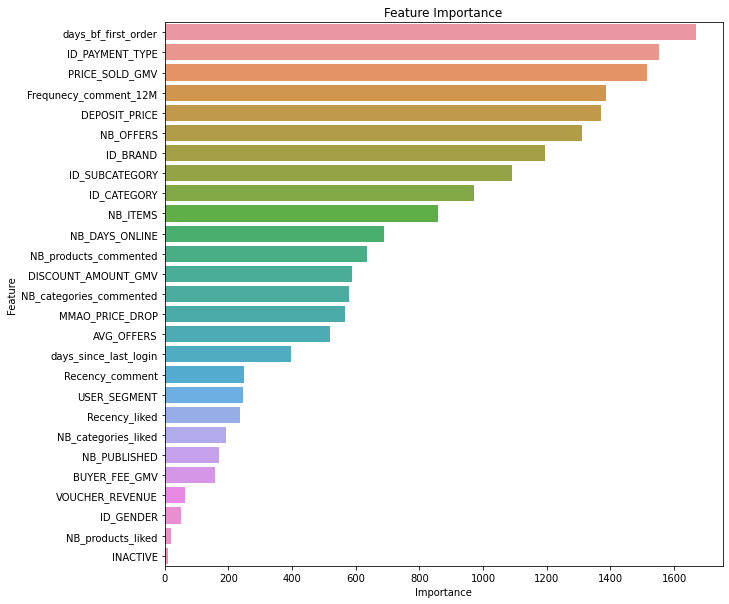

In [19]:
best_model_LGBM_class, df_classification_result, repeater_pred_proba = hyperparameter_tuning_lgbm(X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER)

# Model 2 : Predicting the Customer Lifetime Value (CLV) of a customer 

In [40]:
X_train_CLTV_scaled, X_test_CLTV_scaled = pre_processing(df_sample, X_train_CLTV, X_test_CLTV, scaling=True, scaler='MinMaxScaler')

In [41]:
def regression_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the regression model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_regression_result where each row represents the result of one model
    The columns should be the name of the model, the mean absolute error, the mean squared error and the root mean squared error

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(),
                'ElasticNet Regression': ElasticNet(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor( n_jobs=-1),
                'Gradient Boosting': GradientBoostingRegressor(), 'CatBoost': CatBoostRegressor(verbose=0), 
                'XGBoost': XGBRegressor(n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror', booster='gbtree', tree_method='gpu_hist'),
                'LightGBM': LGBMRegressor(n_jobs=-1, random_state=42, boosting_type='gbdt', objective='regression'),}
    
    df_regression_result = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        df_regression_result = df_regression_result.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')


    print('Finished fitting and evaluating all the models')
    
    df_regression_result = df_regression_result.sort_values(by='R2', ascending=False)

    df_regression_result.reset_index(drop=True, inplace=True)

    return df_regression_result
        

In [42]:
df_regression_result = regression_model_testing(df_sample, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

Linear Regression has been fitted and evaluated
It took 0.2568941116333008 seconds to fit and evaluate the model
--------------------------------------
Ridge Regression has been fitted and evaluated
It took 0.08294081687927246 seconds to fit and evaluate the model
--------------------------------------
Lasso Regression has been fitted and evaluated
It took 0.8077468872070312 seconds to fit and evaluate the model
--------------------------------------
ElasticNet Regression has been fitted and evaluated
It took 0.15621018409729004 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 7.065490961074829 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 84.45498847961426 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 65.38473296165466 seconds to fit and e

In [43]:
df_regression_result # with whole dataset with correct table

,Model,MAE,MSE,RMSE,R2
0,XGBoost,474.114310,2.615405e+07,5114.102927,0.276924
1,CatBoost,465.900050,2.649411e+07,5147.243335,0.267523
2,Random Forest,456.703455,2.678472e+07,5175.396080,0.259488
3,Gradient Boosting,510.898922,2.691890e+07,5188.342877,0.255779
4,LightGBM,465.574623,2.783894e+07,5276.261916,0.230343
5,Linear Regression,705.872051,2.844899e+07,5333.759336,0.213477
6,Ridge Regression,719.537312,2.867176e+07,5354.602007,0.207318
7,Lasso Regression,707.094665,2.869661e+07,5356.922090,0.206631
8,Decision Tree,549.829671,2.932014e+07,5414.807401,0.189392
9,ElasticNet Regression,976.502129,3.592647e+07,5993.869483,0.006748


In [26]:
df_regression_result # with whole dataset

,Model,MAE,MSE,RMSE,R2
7,CatBoost,398.410215,1.032647e+06,1016.192508,0.996982
8,XGBoost,362.918831,1.323120e+06,1150.269387,0.996134
5,Random Forest,141.183467,1.369425e+06,1170.224385,0.995998
9,LightGBM,513.009730,1.684276e+06,1297.796591,0.995078
4,Decision Tree,117.574250,2.288183e+06,1512.674177,0.993314
6,Gradient Boosting,979.093036,5.180002e+06,2275.961839,0.984863
0,Linear Regression,4150.498663,2.342153e+08,15304.093705,0.315589
2,Lasso Regression,4125.146472,2.344593e+08,15312.064253,0.314875
1,Ridge Regression,4129.048987,2.349818e+08,15329.116354,0.313349
3,ElasticNet Regression,3871.030253,3.354899e+08,18316.382689,0.019649


In [14]:
df_regression_result # with subset of 10k rows

,Model,MAE,MSE,RMSE,R2
7,CatBoost,653.996897,7.072158e+06,2659.352880,0.984309
8,XGBoost,603.669981,1.350063e+07,3674.319974,0.970046
5,Random Forest,684.012501,2.313612e+07,4810.002254,0.948667
6,Gradient Boosting,1214.272964,3.025024e+07,5500.021396,0.932883
9,LightGBM,958.391923,3.695194e+07,6078.810457,0.918014
4,Decision Tree,786.999319,7.362363e+07,8580.421458,0.836650
2,Lasso Regression,4551.796817,2.803922e+08,16744.915110,0.377888
1,Ridge Regression,4486.309179,2.806341e+08,16752.136214,0.377352
0,Linear Regression,4587.290900,2.812946e+08,16771.838966,0.375886
3,ElasticNet Regression,4225.078786,4.387155e+08,20945.536347,0.026613


In [15]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def xgb_evaluation(df, X_train, X_test, y_train, y_test):
    '''
    df : dataframe qui contient les données à analyser

    outliers: booléen qui permet de supprimer les outliers ou non
    -> outliers = True : on supprime les outliers
    -> outliers = False : on ne supprime pas les outliers
    
    Fonction qui permet d'effectuer une Grid Search sur les hyperparamètres du modèle XGBoost
    Ensuite, on évalue le modèle avec les meilleurs hyperparamètres

    return: y_pred : les prédictions du modèle, model : le modèle avec les meilleurs hyperparamètres

    '''
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle XGBoost
    param_grid = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(2, 10),
    'subsample': Real(0.1, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'reg_lambda': Real(1e-9, 1000, prior='log-uniform'),
    'reg_alpha': Real(1e-9, 1.0, prior='log-uniform'),
    'gamma': Real(1e-9, 0.5, prior='log-uniform'),
    'min_child_weight': Integer(1, 10)}


    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)

    start = time.time() # début du chronomètre
    
    bayes_cv_tuner = BayesSearchCV(
        xgb_model,
        param_grid,
        n_iter=100,
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42)

    # fit the model with the training data
    bayes_cv_tuner.fit(X_train, y_train)

    # print the best parameters and score
    print(bayes_cv_tuner.best_params_)
    print(bayes_cv_tuner.best_score_)

    # Evaluation du modèle avec les meilleurs hyperparamètres
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    # create a new model with the best parameters
    gbr = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **bayes_cv_tuner.best_params_)

    # train the model
    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    # make predictions with the trained model
    y_pred = model_test.predict(xgtest)

    # save the preds in numpy array

    np.save('CLTV_pred_xgb.npy', y_pred)

    end= time.time() # fin du chronomètre

    print(f'It took {end-start} seconds to tune, fit and evaluate the model')

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    print('---------')

    print(f'MSE = {MSE}')
    print(f'RMSE = {RMSE}')
    print(f'MAE = {MAE}')
    print(f'R2 = {R2}')

    print('---------')

    # create a dataframe with the model and scores 

    df_model = pd.DataFrame({'Model': ['XGBoost_Tuned'], 'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]})


    print('Evaluation finie !')

    print('---------')

    # plot feature importance pour le modèle XGBoost

    feature_importance = model_test.get_score(importance_type='total_gain')
    feature_importance = list(feature_importance.values())
    sorted_feature_importance = sorted(feature_importance, reverse=False)
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x=sorted_feature_importance, y=colnames, orient='h')
    plt.title('XGBoost Feature importance')
    plt.show()

    print('---------')

    # plot residual plot pour le modèle XGBoost

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')

    plt.title(f'Régression du modèle XGBoost, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    plt.show()

    print('-------')
    print('Fin de l\'évaluation du modèle XGBoost !') 

    # save the model as a pickle file in the models folder

    with open('models/CLTV_xgb_model_Sample.pkl', 'wb') as file:
        pkl.dump(model_test, file)

    return df_model, model_test, y_pred

OrderedDict([('colsample_bytree', 0.14655755030192608), ('gamma', 0.49999999999999994), ('learning_rate', 0.031598935673159446), ('max_depth', 7), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 1.21723810917677e-06), ('reg_lambda', 0.006629005237738877), ('subsample', 0.7648237104299075)])
0.974041758734592
It took 2058.0679132938385 seconds to tune, fit and evaluate the model
---------
MSE = 7882754.487482022
RMSE = 2807.62434942462
MAE = 848.1314889364373
R2 = 0.9825103764201375
---------
Evaluation finie !
---------


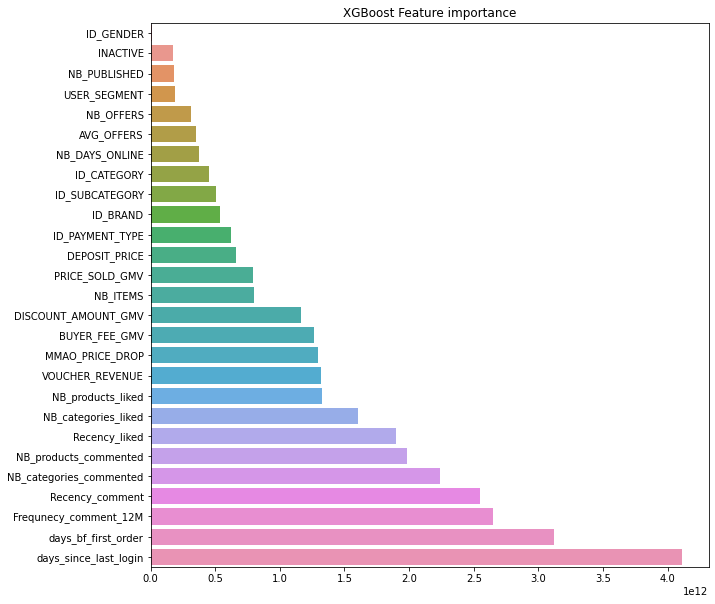

---------


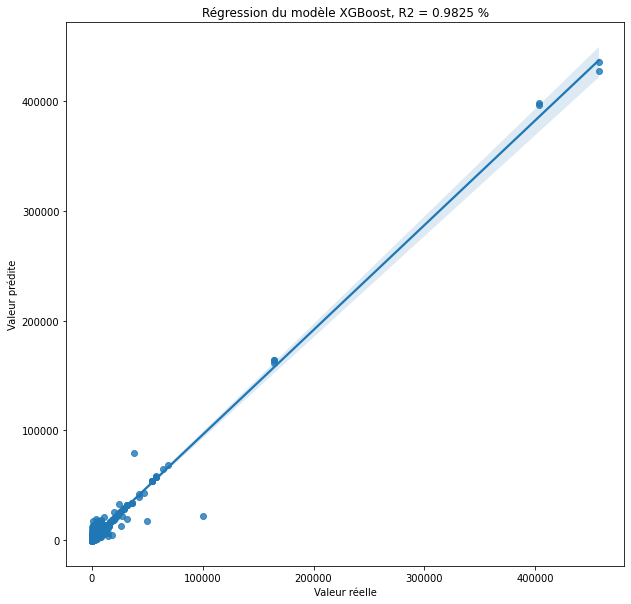

-------
Fin de l'évaluation du modèle XGBoost !


In [16]:
df_xgboost_tuned, model_test_xgb, cltv_pred_xgb = xgb_evaluation(df_sample, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

In [49]:
# compare the predictions with the real values of cltv_pred_xgb and y_test_CLTV

cltv_pred_xgb = pd.DataFrame(cltv_pred_xgb, columns=['CLTV_pred_xgb'])

cltv_pred_xgb['CLTV_pred_xgb'] = cltv_pred_xgb['CLTV_pred_xgb'].apply(lambda x: round(x, 2))

y_test_CLTV = pd.DataFrame(y_test_CLTV, columns=['CLTV'])

y_test_CLTV.reset_index(drop=True, inplace=True)

cltv_pred_xgb.reset_index(drop=True, inplace=True)

cltv_pred_xgb = pd.concat([cltv_pred_xgb, y_test_CLTV], axis=1)

cltv_pred_xgb['CLTV_diff'] = cltv_pred_xgb['CLTV'] - cltv_pred_xgb['CLTV_pred_xgb']

# print rows where values are negative

cltv_pred_xgb[cltv_pred_xgb['CLTV_pred_xgb'] < 0]






,CLTV_pred_xgb,CLTV,CLTV_diff
14,-19.60,53.892216,73.492216
15,-78.42,113.105781,191.525781
23,-7.38,41.958042,49.338042
35,-308.63,539.166102,847.796102
54,-325.05,66.746126,391.796126
87,-197.39,481.162800,678.552800
90,-56.36,147.343400,203.703400
91,-41.93,269.544900,311.474900
96,-4.62,118.250000,122.870000
110,-66.23,60.313631,126.543631


In [37]:
# hyperparamter tuning for LightGBM
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=42)

    start= time.time()
    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'Bayesian Search took {end - start} seconds')

    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    #keep the y_pred in a file for later use 

    np.savetxt('CLTV_pred_lgbm.txt', y_pred)

    # Evaluate the model

    print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')


    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()


    # plot residual plot pour le modèle LightGBM

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')
    plt.title(f'Régression du modèle LightGBM, R2 = {np.round(r2_score(y_test, y_pred),4)} %')
    plt.show()

    # save the model as a pickle file in the models folder

    with open('models/CLTV_lgbm_model_Sample.pkl', 'wb') as file:
        pkl.dump(bayes_cv_tuner.best_estimator_, file)

    return bayes_cv_tuner.best_estimator_, y_pred

Bayesian Search took 315.8858959674835 seconds
Best score:  -8621713.149166485
Best params:  OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.188069801474748), ('max_depth', 8), ('min_child_samples', 52), ('n_estimators', 1000), ('num_leaves', 100), ('reg_alpha', 0.047602238801102634), ('reg_lambda', 0.5), ('subsample', 0.5)])
MSE score: 41266177.46502259
RMSE score: 6423.875579821155
MAE score: 1063.0680560127896
R2 score: 0.9084419143601175


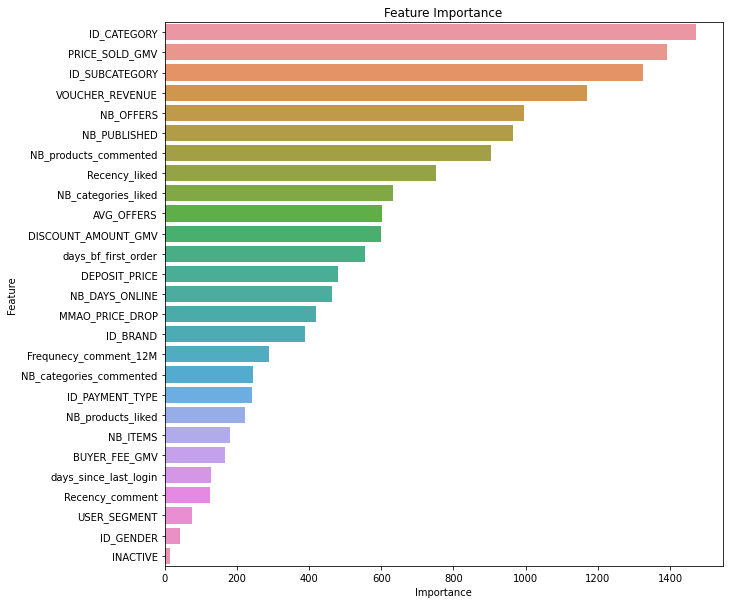

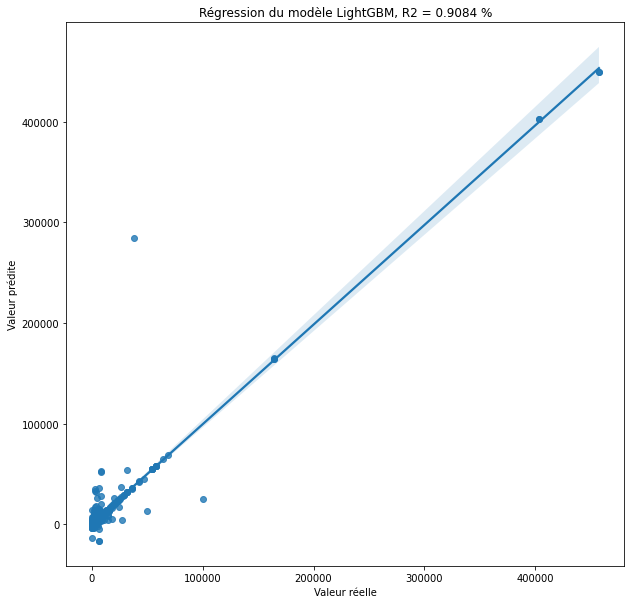

In [38]:
best_model_lgbm, cltv_pred_lgbm = hyperparameter_tuning_lgbm(X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

# Model 3: Scoring Model

## Weigthed Average Model

In [53]:
# Use the predicted Repeater rate & the predicted CLTV  

weight_repeater = 0.7
weight_CLTV = 0.3

repeater_pred_proba = np.loadtxt('REPEATER_pred_proba.txt')

cltv_pred_lgbm = np.load('CLTV_pred_xgb.npy') 

composite_score = weight_repeater * repeater_pred_proba + weight_CLTV * cltv_pred_lgbm

WA_df = X_test_REPEATER.copy()
WA_df['Composite_Score'] = composite_score

# normalise the composite score between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()

WA_df['Composite_Score'] = scaler.fit_transform(WA_df[['Composite_Score']])

# keep only the customers with a composite score > 0.5
# rank the customers by their composite scor

WA_df = WA_df.sort_values(by='Composite_Score', ascending=False)

# show where composite score is negative

WA_df.head(10)

,ID_GENDER,INACTIVE,NB_PUBLISHED,USER_SEGMENT,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,ID_CATEGORY,ID_SUBCATEGORY,ID_BRAND,ID_PAYMENT_TYPE,Composite_Score
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15782933,1,0,16,10,780.0,2.437500,63,16200.521617,12668.574847,1.000000,2.86104,15.020800,1792.975812,2.644374,989.0,7.0,0.0,28.0,4.0,12.0,4466.0,29,28,0.356781,0.416500,0.459677,0.477379,1.000000
15782933,1,0,16,10,780.0,2.437500,26,16200.521617,12668.574847,1.000000,2.86104,15.020800,1792.975812,2.644374,989.0,7.0,0.0,28.0,4.0,12.0,4466.0,29,28,0.356781,0.416500,0.459677,0.477379,0.982722
16687639,2,0,169,10,143.0,1.906667,82,3609.573776,3833.612463,1.659794,0.00000,13.758362,-80.607856,0.000000,335.0,5.0,0.0,33.0,4.0,0.0,481.0,170,28,0.356781,0.416500,0.541322,0.477379,0.915207
16687639,2,0,169,10,143.0,1.906667,803,3609.573776,3833.612463,1.659794,0.00000,13.758362,-80.607856,0.000000,335.0,5.0,0.0,33.0,4.0,0.0,481.0,170,28,0.356781,0.416500,0.541322,0.477379,0.911023
16525824,3,0,3,10,475.0,1.962810,9,984.473978,1093.232689,1.536913,0.00000,7.300250,66.909389,0.000000,414.0,6.0,0.0,2.0,2.0,21.0,5.0,0,28,0.553708,0.561462,0.541322,0.483100,0.379303
16525824,3,0,3,10,475.0,1.962810,6,984.473978,1093.232689,1.536913,0.00000,7.300250,66.909389,0.000000,414.0,6.0,0.0,2.0,2.0,21.0,5.0,0,28,0.553708,0.561462,0.541322,0.483100,0.377488
16525824,3,0,3,10,475.0,1.962810,233,984.473978,1093.232689,1.536913,0.00000,7.300250,66.909389,0.000000,414.0,6.0,0.0,2.0,2.0,21.0,5.0,0,28,0.553708,0.561462,0.541322,0.483100,0.371576
15497171,2,0,149,10,210.0,2.727273,0,7633.101852,6383.101852,1.000000,0.00000,16.180556,725.000000,0.000000,207.0,5.0,15.0,37.0,5.0,3.0,5282.0,183,28,0.587786,0.571428,0.472250,0.477379,0.182982
8101105,2,0,0,10,966.0,1.808989,151,1253.575105,992.976505,5.608696,0.00000,8.137257,6.644008,0.000000,802.0,7.0,2.0,16.0,3.0,1.0,2240.0,1092,29,0.553708,0.416500,0.541322,0.436869,0.159766


# Uplift Model

In [28]:
# Add a treatment column to the dataframe
# Randomly assign a 0 or 1 to each row. 1 for treatment, 0 for control
df['treatment'] = np.random.randint(2, size=len(df))

In [29]:
df.treatment.value_counts()

1    53977
0    53788
Name: treatment, dtype: int64

In [30]:
# Let's check the treatment's correlation to repeat purchases:
def correlation_treatment(df:pd.DataFrame):
    """Function to calculate the treatment's correlation
    """
    correlation = df[['treatment','REPEATER']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['REPEATER'] * 100,2)))

correlation_treatment(df)

,REPEATER
treatment,0.24
REPEATER,100.00


In [31]:
def declare_target_class(df:pd.DataFrame):
    """Function for declare the target class
    """
    # Control Non Repeaters (CN) : 0
    df['target_class'] = 0 
    # Control Repeaters (CR) : 1
    df.loc[(df.treatment == 0) & (df.REPEATER == 0),'target_class'] = 1 
    # Treatment Non Repeaters (TN) : 2
    df.loc[(df.treatment == 1) & (df.REPEATER == 1),'target_class'] = 2 
    # Treatment Repeaters (TR) : 3
    df.loc[(df.treatment == 1) & (df.REPEATER == 0),'target_class'] = 3 
    return df

df = declare_target_class(df)

In [34]:
df.head()

,ID_GENDER,INACTIVE,NB_PUBLISHED,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,ID_CATEGORY,ID_SUBCATEGORY,ID_BRAND,ID_PAYMENT_TYPE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,treatment,target_class
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15347487,2,0,1,10,1.0,4011.086544,55.0,1.447368,61,[13. 14. 63.],[ 54. 598.],14,65,505.853754,443.753592,1.0,12.464280,9.906643,18.370339,12.464280,185.0,5.0,9.0,2.0,1.0,204.0,406.0,163,33,0,0
17180639,2,0,1,4,0.0,684.884065,20.0,2.222222,198,[13. 14. 63.],[507. 598. 609.],[ 14 650 3119],65,247.010703,170.155022,3.0,7.751938,17.441860,39.033872,7.751938,44.0,5.0,68.0,0.0,0.0,999.0,0.0,20,63,1,3
13154196,1,0,0,5,0.0,239.520964,136.0,1.700000,469,13.0,84.0,[ 47 58 187],45,173.410970,79.840321,3.0,7.984032,0.000000,15.037268,7.984032,29.0,2.0,319.0,0.0,0.0,999.0,0.0,216,163,0,1
16618931,1,0,0,1,0.0,273.159145,0.0,0.000000,77,14.0,125.0,94,55,271.867612,273.159145,1.0,23.752969,0.000000,0.000000,23.752969,0.0,0.0,999.0,0.0,0.0,999.0,0.0,1,291,1,3
15612679,2,0,0,2,0.0,209.625000,0.0,0.000000,2,13.0,510.0,191,56,195.000000,209.625000,1.0,0.000000,17.730496,0.000000,0.000000,1.0,1.0,340.0,0.0,0.0,999.0,0.0,1,160,1,3


In [35]:
def split_data(df:pd.DataFrame):
    """Split data into training data and testing data
    """
    X = df.drop(['REPEATER', 'CLTV','target_class','ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE'],axis=1)
    y = df.REPEATER
    z = df.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def machine_learning(X_train:pd.DataFrame,
                     X_test:pd.DataFrame,
                     y_train:pd.DataFrame,
                     y_test:pd.DataFrame,
                     z_train:pd.DataFrame,
                     z_test:pd.DataFrame):
    """Machine learning process consists of 
    data training, and data testing process (i.e. prediction) with XGBoost (XGB) Algorithm
    """

    # prepare a new DataFrame
    prediction_results = pd.DataFrame(X_test).copy()
    
    
    # train the ETP model
    model_tp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # prediction Process for ETP model 
    prediction_tp \
    = model_tp.predict(X_test.drop('treatment',axis=1))
    probability__tp \
    = model_tp.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_REPEATER'] = prediction_tp
    prediction_results['proba_REPEATER'] = probability__tp[:,1]
    
    
    # train the ETU model
    model_etu \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # prediction Process for ETU model 
    prediction_etu \
    = model_etu.predict(X_test.drop('treatment', axis=1))
    probability__etu \
    = model_etu.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_target_class'] = prediction_etu
    prediction_results['proba_CN'] = probability__etu[:,0] 
    prediction_results['proba_CR'] = probability__etu[:,1] 
    prediction_results['proba_TN'] = probability__etu[:,2] 
    prediction_results['proba_TR'] = probability__etu[:,3]
    prediction_results['score_etu'] = prediction_results.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # add the REPEATER and target class into dataframe as validation data
    prediction_results['REPEATER'] = y_test
    prediction_results['target_class'] = z_test
    return prediction_results


def predict(df:pd.DataFrame):
    """Combining data split and machine learning process with XGB
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df)
    prediction_results = machine_learning(X_train,
                                          X_test,
                                          y_train,
                                          y_test,
                                          z_train,
                                          z_test)
    print("✔️Prediction succeeded")
    return prediction_results

# Machine Learning Modelling Process
print("Predicting dataset 1 ...")
prediction_results_1 = predict(df)

Predicting dataset 1 ...
✔️Prediction succeeded


### Evaluating predictive performance

In [36]:
def cm_evaluation(df:pd.DataFrame):
    """Confusion matrix evaluation
    """  
    print("===================================")
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df['REPEATER'], df['prediction_REPEATER'])
    df_confusion_etp = pd.DataFrame(confusion_etp, columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_confusion_etp)
    
    print("-----------------------------------")
    
    print("2. ETU's confusion matrix result:")   
    confusion_etu = multilabel_confusion_matrix(df['target_class'], df['prediction_target_class'])
    print("a. CN's confusion matrix:")  
    df_cn = pd.DataFrame(confusion_etu[0], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cn)
    print("b. CR's confusion matrix:") 
    df_cr = pd.DataFrame(confusion_etu[1], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cr) 
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(confusion_etu[2], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tn) 
    print("d. TR's confusion matrix:") 
    df_tr = pd.DataFrame(confusion_etu[3], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tr)
    
    print("===================================")

In [37]:
# Confusion Matrix Evaluation
print("✔️Dataset 1")
cm_evaluation(prediction_results_1)

✔️Dataset 1
1. ETP's confusion matrix result:
              Predicted True  Predicted False
Actual True            13702             3692
Actual False            2498            12438
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
              Predicted True  Predicted False
Actual True            20040             4870
Actual False            4442             2978
b. CR's confusion matrix:
              Predicted True  Predicted False
Actual True            18863             4750
Actual False            5249             3468
c. TN's confusion matrix:
              Predicted True  Predicted False
Actual True            19804             5010
Actual False            4311             3205
d. TR's confusion matrix:
              Predicted True  Predicted False
Actual True            18963             4690
Actual False            5318             3359


In [38]:
def accuracy_evaluation(df:pd.DataFrame):
    """Accuracy evaluation
    """
    akurasi_cp = accuracy_score(df['REPEATER'],
                                df['prediction_REPEATER'])
    print('✔️ETP model accuracy: %.2f%%' % (akurasi_cp * 100.0))
    
    
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediction_target_class'])
    print('✔️ETU model accuracy: %.2f%%' % (akurasi_uplift * 100.0))

In [39]:
# Accuracy Evaluation Process.
print("Dataset 1")
accuracy_evaluation(prediction_results_1)

Dataset 1
✔️ETP model accuracy: 80.85%
✔️ETU model accuracy: 40.24%


### Evaluation of the prescriptive performance

In [40]:
def sorting_data(df:pd.DataFrame):
    """Function to sort data
    """
    # Set up new DataFrames for ETP model and ETU model
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    
    
    # Add quantiles
    df_c['n'] = df.proba_REPEATER.rank(pct=True, ascending=False)
    df_u['n'] = df.score_etu.rank(pct=True, ascending=False)
    df_c['score'] = df['proba_REPEATER']
    df_u['score'] = df['score_etu']
    
    
    # Ranking the data by deciles
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Calculate the C, T, CR, and TR
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    

    # Calculate & add the qini value into the Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    qini_coef= df['uplift'].sum(skipna = True) - df['random'].sum(skipna = True)

    # Print the Qini coefficient
    print('✔️Qini coefficient = {} {}'.format(round(qini_coef, 2), '%'))
    
    # Add q0 into the Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini

def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df_u['model'] = 'ETU'
    df_c['model'] = 'ETP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot the qini curve
    """
    print('\nPlotting the qini curve...')
    
    # Define the data that will be plotted
    order = ['ETU','ETP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    
    # Additional plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    print('✔️Successfully plot the qini curve')
    return ax

def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_c, df_u = sorting_data(prediction_results)
    print('ETP model (previous model):')
    qini_c = calculating_qini(df_c)
    print('\nETU model (our proposed model):')
    qini_u = calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini


ETP model (previous model):
✔️Qini coefficient = -1.34 %

ETU model (our proposed model):
✔️Qini coefficient = 24.8 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

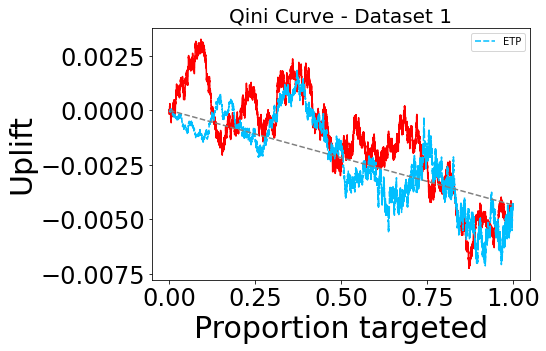

In [41]:
# Qini evaluation results for DataSet 1 with negative treatment correlation
ax, qini_1 = evaluation_qini(prediction_results_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)

✔️Treatment correlation in dataset 1 (inverted): -0.24
✔️Prediction succeeded
ETP model (previous model):
✔️Qini coefficient = 9.33 %

ETU model (our proposed model):
✔️Qini coefficient = 41.99 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

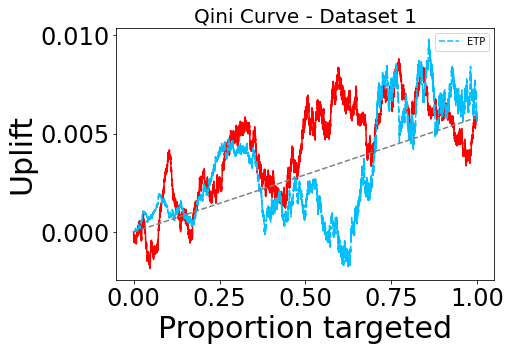

In [42]:
# The process to inverse treatment's parameter
# Thus also inverse the treatment's correlation from negative to positive
df.treatment = df.treatment.replace({0: 1, 1: 0})

# Recalculate the treatment correlation
print("✔️Treatment correlation in dataset 1 (inverted):", correlation_treatment(df).iloc[0,0])

# Add the target class feature to all three datasets
df_inverse = declare_target_class(df)

# Do the prediction process once more time
prediction_results_inverse_1 = predict(df_inverse)

# Qini evaluation results for DataSet 1 with positive treatment correlation
ax, qini_inverse_1 = evaluation_qini(prediction_results_inverse_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)

## Implementation of our solution

Test with people who had only one purchase